# The Metropolis-Hastings Test

This runs a quick example of the Metropolis-Hastings test on the example from Section 5.1 in [1]. We know the true posterior distribution and can visualize it through contour plots, so we can inspect the MH test output to ensure that it matches what we expect. 

Our MCMC chain samples for values of $\theta \in \mathbb{R}^2$. The prior is a 2-D Gaussian centered at zero with diagonal covariance matrix $\Sigma = {\rm diag}(10, 1)$.

The proposal distribution is a simple Gaussian distribution, meaning that it is symmetric so the proposal distribution can be ignored.

[1] Max Welling and Yee Whye Teh. Bayesian Learning via Stochastic Gradient Langevin Dynamics, *International Conference on Machine Learning, 2011*.

(array([  3.,   0.,   2.,   3.,   5.,   2.,   3.,   9.,   8.,   8.,  15.,
         11.,   7.,   7.,  10.,   1.,   1.,   3.,   0.,   2.]),
 array([-3.52608003, -3.14107489, -2.75606975, -2.37106461, -1.98605947,
        -1.60105433, -1.21604919, -0.83104405, -0.4460389 , -0.06103376,
         0.32397138,  0.70897652,  1.09398166,  1.4789868 ,  1.86399194,
         2.24899708,  2.63400222,  3.01900736,  3.4040125 ,  3.78901764,
         4.17402278]),
 <a list of 20 Patch objects>)

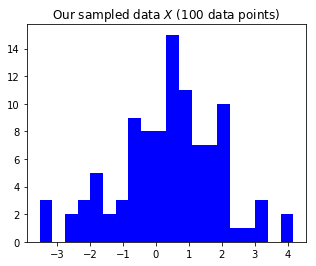

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import sys

# Generate the data according to Section 5.1 of "Bayesian Learning via SGLD" (2011).
num_points = 100
sigma1_sq = 10
sigma2_sq = 1
sigmax_sq = 2
theta1 = 0
theta2 = 1

prior_mean = np.array([0,0])
prior_cov  = np.array([[sigma1_sq,0],[0,sigma2_sq]])

# Populate the data matrix.
X = np.zeros(num_points)
for i in range(num_points):
    if (np.random.random() < 0.5):
        X[i] = np.random.normal(theta1, np.sqrt(sigmax_sq))
    else:
        X[i] = np.random.normal(theta1+theta2, np.sqrt(sigmax_sq))

# Visualize the data for a sanity check.
plt.figure(figsize=(5,4))
plt.title("Our sampled data $X$ ({} data points)".format(num_points))
plt.hist(X, bins=20, color='blue')

In [2]:
def log_posterior(theta, X, p_mean, p_cov, x_var):
    """
    The posterior is proportional to`p(\theta) * \prod_{i=1}^N p(x_i | \theta)`.
    X is the data matrix, and assumed to be of shape (n,), by default n = 100.
    The likelihood `p(x_i | \theta)` is given by the standard mixture model formula.
    """
    inv_cov = np.linalg.inv(p_cov)
    determinant = np.prod(np.diagonal(p_cov))
    prior = np.log(1. / (2*np.pi*np.sqrt(determinant))) - 0.5*(theta.T).dot(inv_cov).dot(theta)

    ll_constant = 1. / (np.sqrt(2 * np.pi * x_var))
    L = 0.5 * np.exp(-(1./(2*x_var)) * (X - theta[0])**2) + \
        0.5 * np.exp(-(1./(2*x_var)) * (X - (theta[0]+theta[1]))**2)
    L *= ll_constant
    log_likelihood = np.sum(np.log(L))
    
    assert not np.isnan(prior + log_likelihood)
    return np.squeeze(prior + log_likelihood)
    

def get_noise(eps):
    """ Returns a 2-D multivariate normal vector with covariance matrix diag(eps,eps). """
    return (np.random.multivariate_normal(np.array([0,0]), eps*np.eye(2))).reshape((2,1))


def get_info_for_contour(K=100):
    """ For building the contour plots. """
    xlist = np.linspace(-1.5, 2.5, num=K)
    ylist = np.linspace(-3, 3, num=K)
    X_a,Y_a = np.meshgrid(xlist, ylist)
    Z_a = np.zeros((K,K))
    for i in range(K):
        for j in range(K):
            theta = np.array( [[X_a[i,j]],[Y_a[i,j]]] )
            Z_a[i,j] = log_posterior(theta, X, prior_mean, prior_cov, sigmax_sq) 
    return X_a, Y_a, Z_a

# Run Metropolis-Hastings

This code segment will now run the standard MH test on this data. 

In [3]:
num_passes = 5000
rand_walk_var = 0.03
num_accepted = 0

# Starting point in the sequence, plus list of collected samples.
theta = np.array([[0.5],[0]])
samples = []

for T in range(1,num_passes+1):
    if (T % int(num_passes/10) == 0):
        print("T: {}".format(T))
        
    # Standard MH test. Note that we don't really need the min{1,...} case
    # since the uniform random variable is guaranteed to be <= 1 anyway.
    theta_new = theta + get_noise(rand_walk_var)        
    delta = log_posterior(theta_new, X, prior_mean, prior_cov, sigmax_sq) - \
            log_posterior(theta, X, prior_mean, prior_cov, sigmax_sq)
    assert not np.isnan(np.exp(delta)), "delta: {}".format(delta)
    
    if (np.random.random() < np.min([1, np.exp(delta)])):
        theta = theta_new
        num_accepted += 1
    samples.append(theta)

samples = np.squeeze(np.array(samples))
print("\nsamples.shape: {}".format(samples.shape))
print("num_accepted: {} (out of {}, with acceptance rate: {})".format(
    num_accepted, num_passes, num_accepted/num_passes))

T: 500
T: 1000
T: 1500
T: 2000
T: 2500
T: 3000
T: 3500
T: 4000
T: 4500
T: 5000

samples.shape: (5000, 2)
num_accepted: 3066 (out of 5000, with acceptance rate: 0.6132)


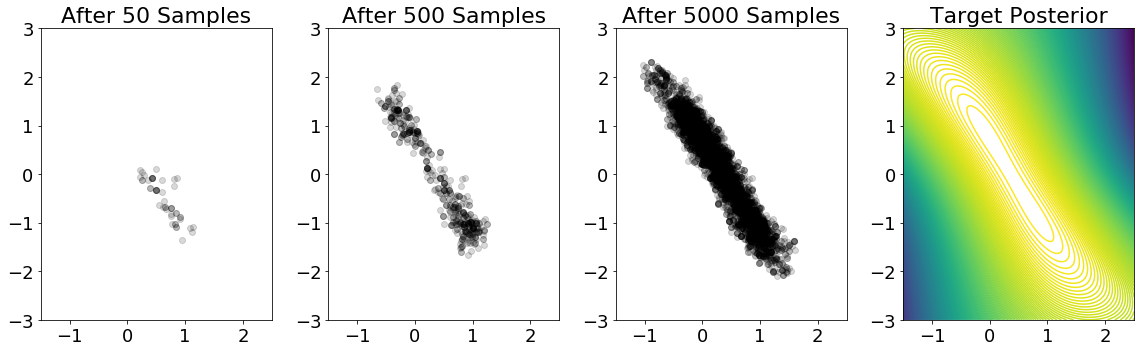

In [4]:
""" Form plots to see sampling progression. """

mymap2 = plt.get_cmap("Greys")
m_c2 = mymap2(400)
fig, axarr = plt.subplots(1,4, figsize=(16, 5))
title_size = 22
axis_size = 18
tick_size = 18
intervals = [50, 500, 5000]

for i,val in enumerate(intervals):
    axarr[i].set_title("After {} Samples".format(val), fontsize=title_size)
    axarr[i].scatter(samples[:val,0], samples[:val,1], color = m_c2, alpha=0.15)

X_a, Y_a, Z_a = get_info_for_contour(K=200)       
axarr[3].set_title("Target Posterior", fontsize=title_size)
axarr[3].contour(X_a,Y_a,Z_a,300)

for i in range(4):
    #axarr[i].set_xlabel("theta_1", fontsize=axis_size)
    #axarr[i].set_ylabel("theta_2", fontsize=axis_size)
    axarr[i].set_xlim([-1.5,2.5])
    axarr[i].set_ylim([-3,3])
    axarr[i].tick_params(axis='x', labelsize=tick_size)
    axarr[i].tick_params(axis='y', labelsize=tick_size)

plt.tight_layout()
plt.savefig("mhtest_example_progression.png")